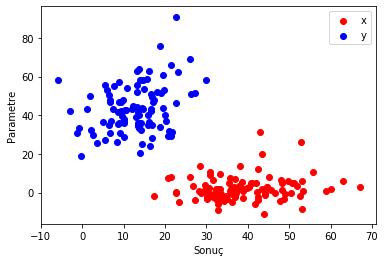

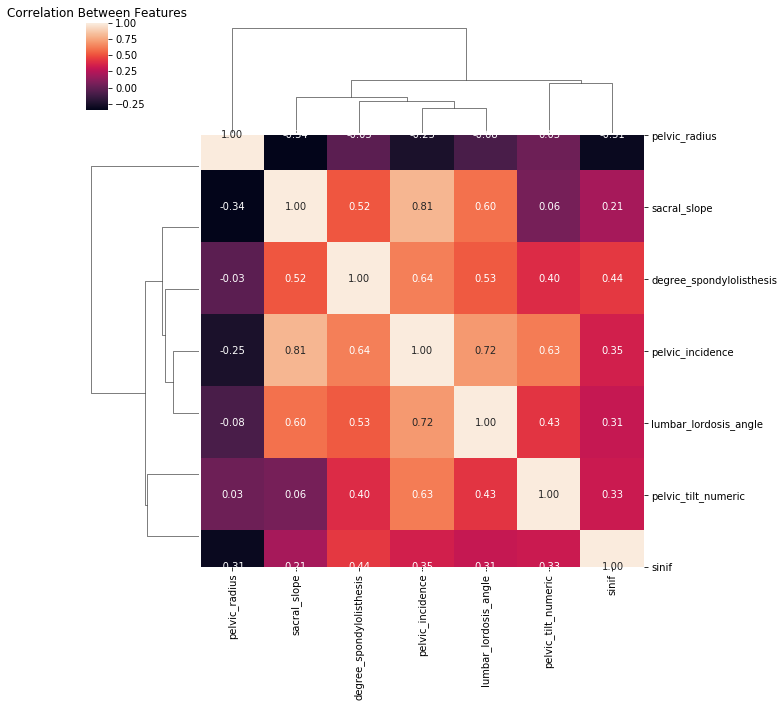

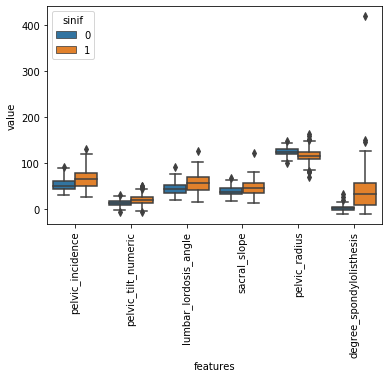

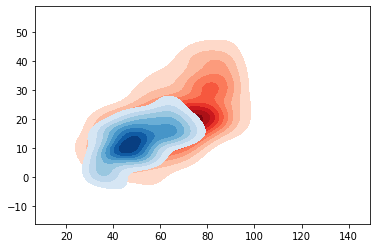

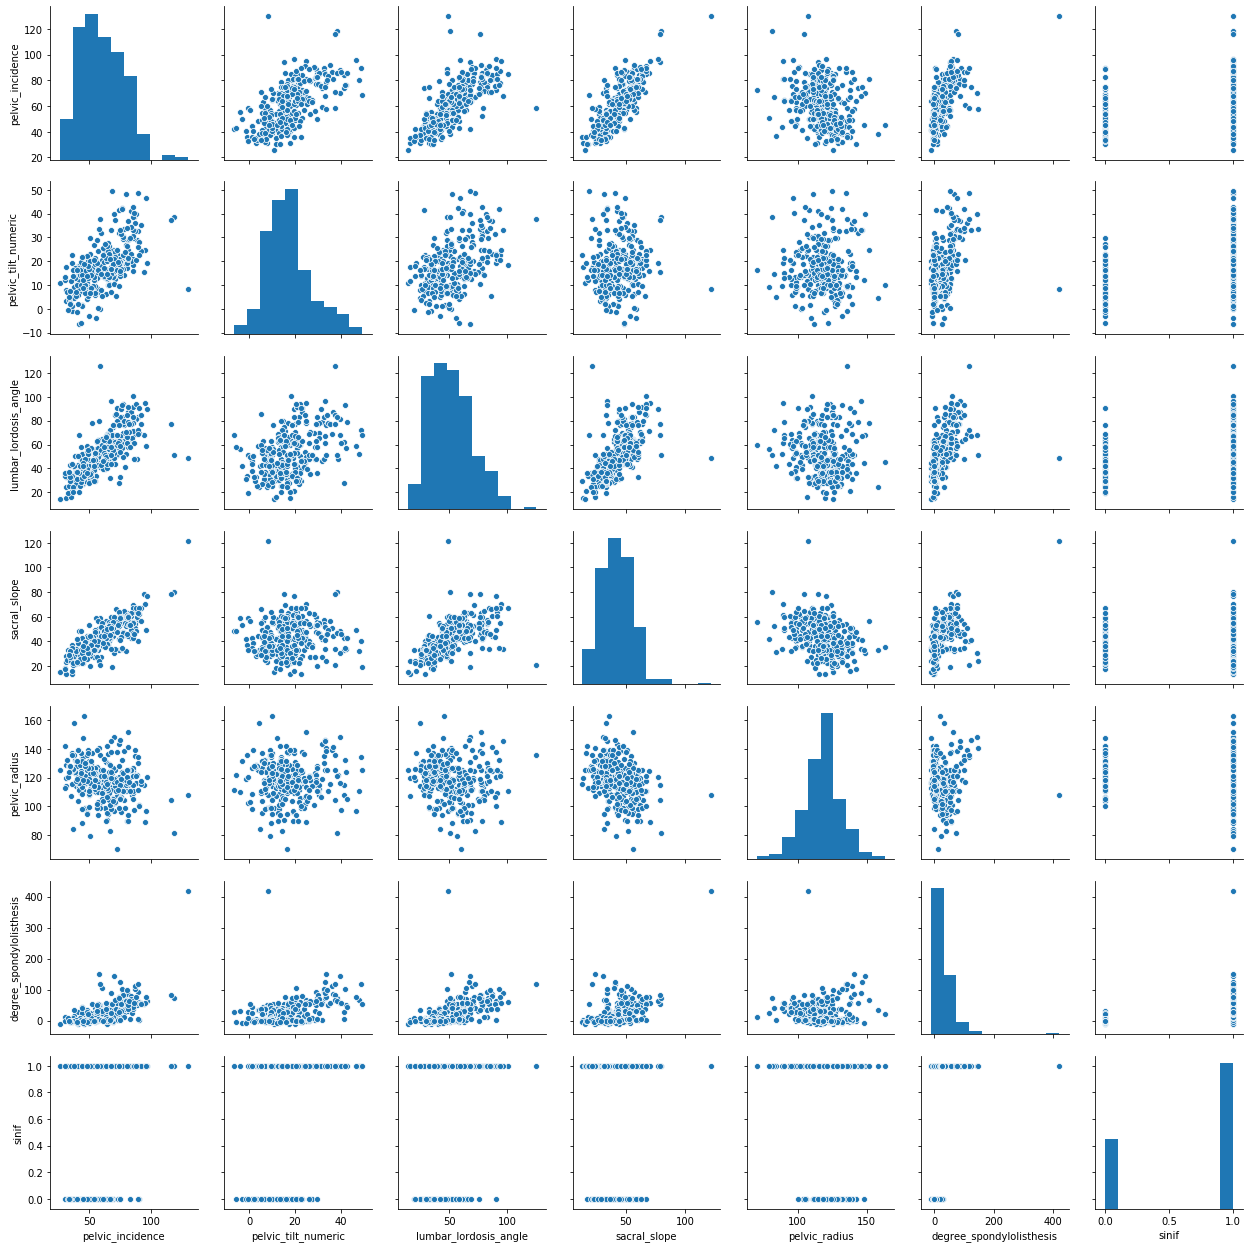

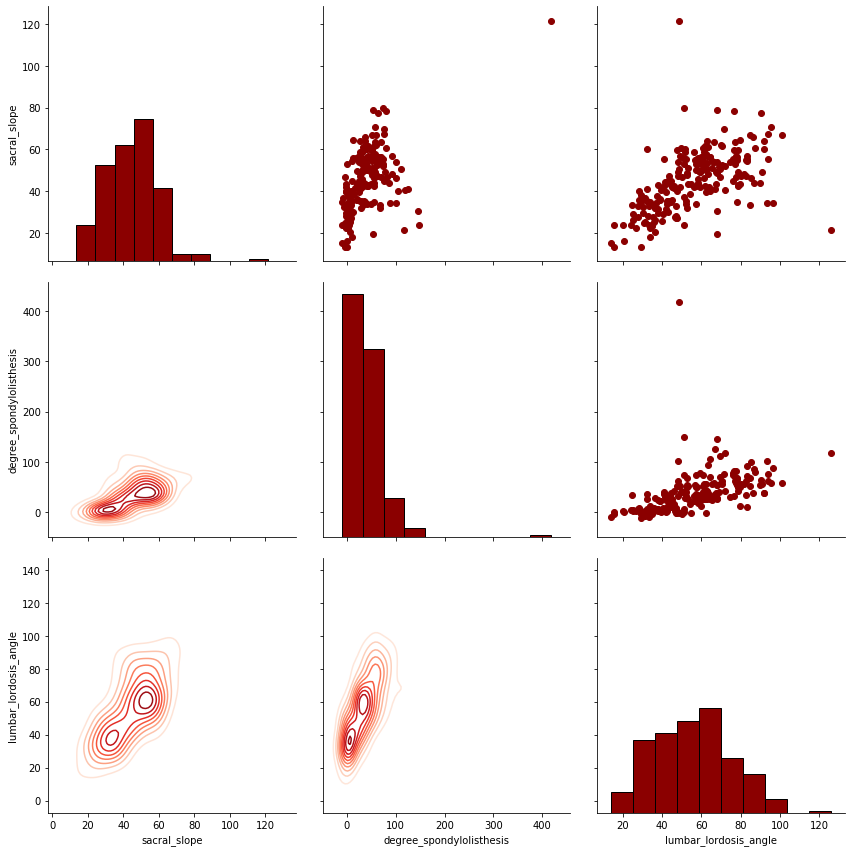

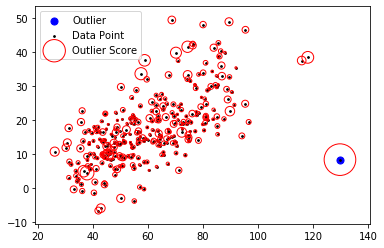

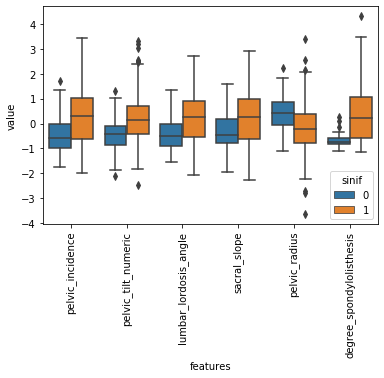

Score:  0.8279569892473119
CM:  [[21  3]
 [13 56]]
Basic KNN Acc:  0.8279569892473119

Best training score: 0.8055555555555556 with parameters: {'n_neighbors': 6, 'weights': 'distance'}

Test Score: 0.8602150537634409, Train Score: 1.0

CM Test:  [[22  2]
 [11 58]]
CM Train:  [[ 76   0]
 [  0 140]]


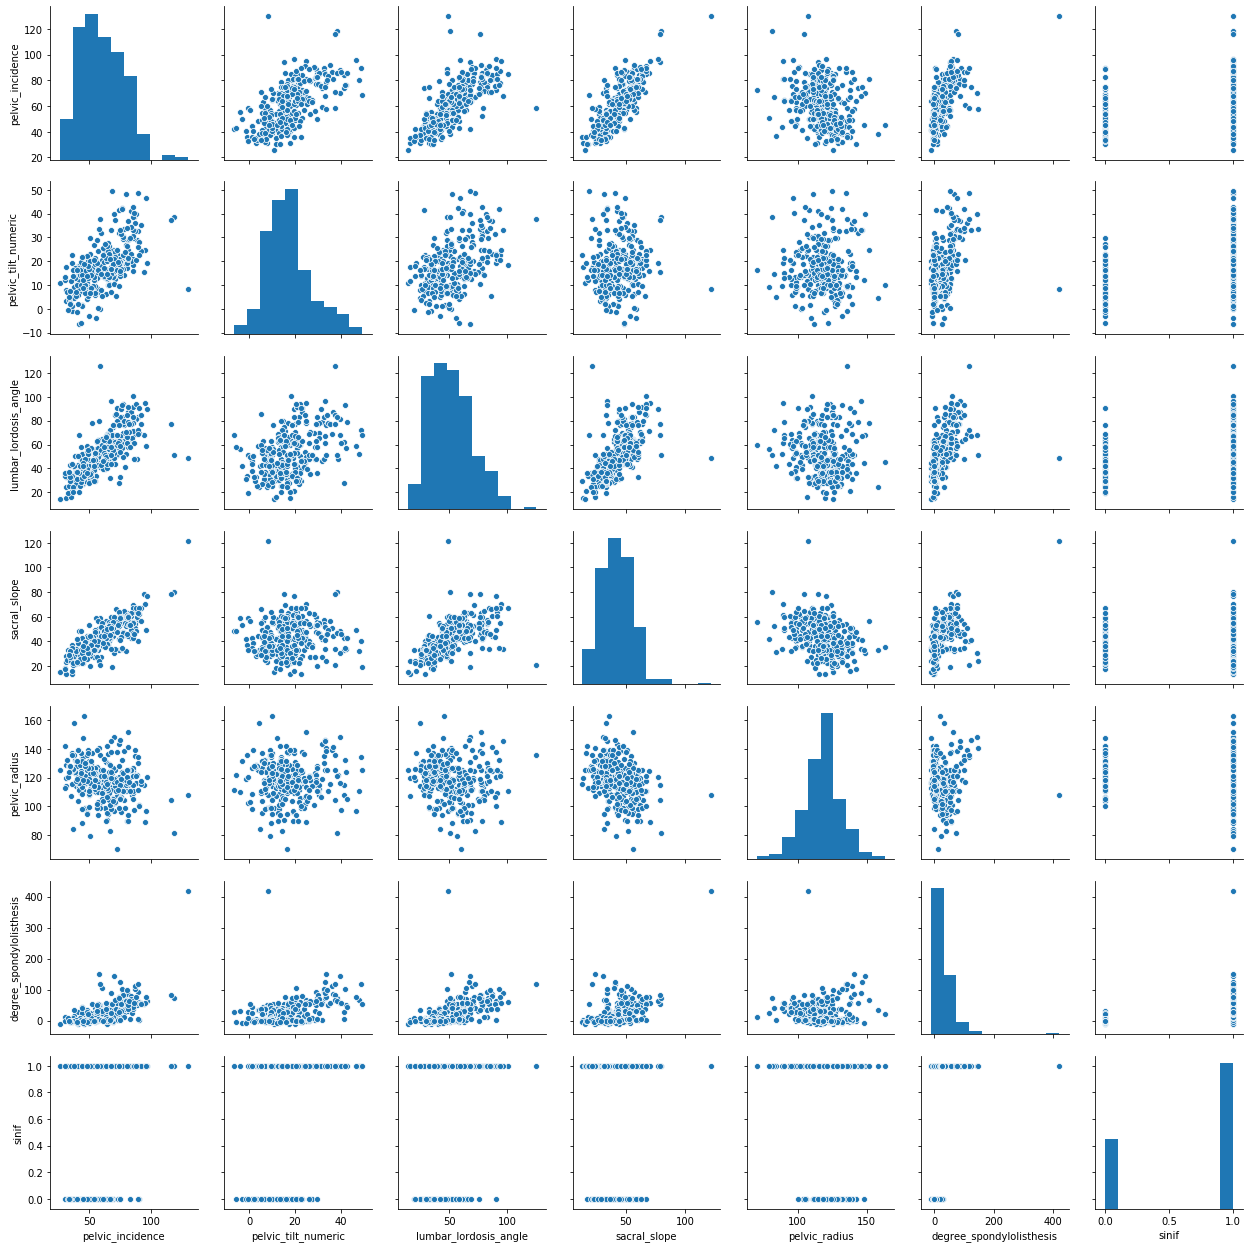

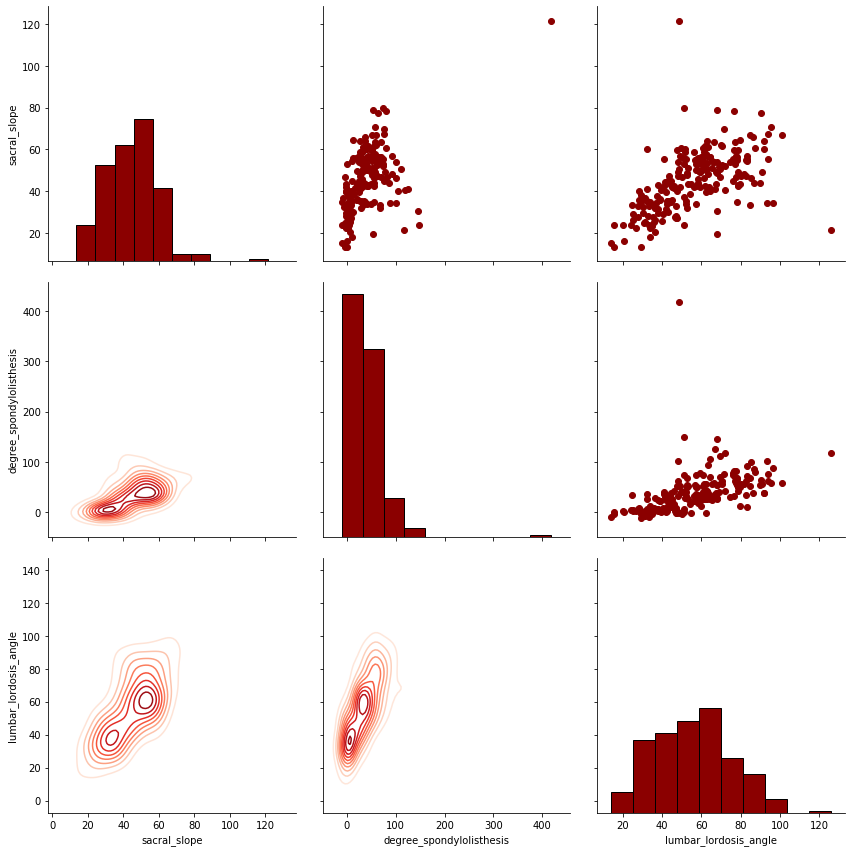

In [3]:
# Gerekli kütüphane tanımlamaları ------------------------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Görselleştirme için import edildi
from matplotlib.colors import ListedColormap

# Standardization yapabilmek için gerekli
from sklearn.preprocessing import StandardScaler 

# KNN en iyi parametreleri bulurken kullanmak üzere import ettik
from sklearn.model_selection import train_test_split, GridSearchCV

# Test sonucundaki hataları bulmak için kullanılır | Hata Matrisi
from sklearn.metrics import accuracy_score, confusion_matrix

# Outlier detect işlemi için gerekli
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor

# uyarı kütüphanesi
import warnings
warnings.filterwarnings("ignore")








# Veri seti yükleme -------------------------------------------------------------------------------------
data = pd.read_csv("column_2C.csv")








# class feature'ın isminin sinif olarak değiştirilmesi ---------------------------------------------------
data = data.rename(columns = {"class":"sinif"})








# scatter ile iki farklı sınıf olarak görselleştirme -----------------------------------------------------
# String olan feature'lar char'a dönüştürüldü
A = data[data.sinif=='Abnormal']
N = data[data.sinif=='Normal']

plt.scatter(N.sacral_slope, N.degree_spondylolisthesis, color="red", label="x")
plt.scatter(N.pelvic_tilt_numeric, N.lumbar_lordosis_angle, color="blue", label="y")
plt.xlabel("Sonuç")
plt.ylabel("Parametre")
plt.legend()








# sinif feature'ınde bulunan string değerlerin (Abnormal-Normal | 1-0) olarak değiştirilmesi -------------
def renameA(x):
    if x== 'Abnormal':
        return 1
    if x== 'Normal':
        return 0
    
data['sinif'] = data['sinif'].apply(renameA)








# data.describe'I describe değişkenine atadık--------------------------------------------------------------
describe = data.describe()








# Korelasyon işleminin gerçekleştirilmesi ve görselleştirilmesi -----------------------------------------
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation Between Features")
plt.show()








# Box Plot işlemi ----------------------------------------------------------------------------------------

# iki farklı class olduğu için iki farklı class şeklinde görselleştireceğiz ve data melt edilir
data_melted = pd.melt(data, id_vars = "sinif",
                      var_name = "features",
                      value_name = "value")

# yeni bir figür oluşturduk
plt.figure() 

# x-feature , y-value ve sinif diyerek classlara göre ayırdık
sns.boxplot(x = "features", y = "value", hue = "sinif", data = data_melted)

# feature isimleri 90 derece döndürülmüş şekilde verilecek
plt.xticks(rotation = 90)
plt.show()








# Farklı 2 sınıfın kdeplot ile gösterimi ---------------------------------------------------------------
pelvic_tilt_numeric = data.loc[data.sinif == 1]
sacral_slope = data.loc[data.sinif == 0]

ax = sns.kdeplot(pelvic_tilt_numeric, pelvic_tilt_numeric,
                 cmap="Reds", shade=True, shade_lowest=False)

ax = sns.kdeplot(sacral_slope, sacral_slope,
                 cmap="Blues", shade=True, shade_lowest=False)








#print -> Sinif : 1 (Abnormal) pairplot ile çizimi ------------------------------------------------------
sns.pairplot(data)
grid = sns.PairGrid(data= data[data['sinif'] == 1],
                    vars = ['sacral_slope', 'degree_spondylolisthesis', 
                    'lumbar_lordosis_angle'], size = 4)
    
# Map a scatter plot to the upper triangle
grid = grid.map_upper(plt.scatter, color = 'darkred')

# Map a histogram to the diagonal
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')








# outlier - inlier ------------------------------------------------------------------------------------
y = data.sinif
x = data.drop(["sinif"], axis = 1)
columns = x.columns.tolist()

clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x)

X_score = clf.negative_outlier_factor_

outlier_score = pd.DataFrame()
outlier_score["score"] = X_score

# outlier threshold
threshold = -2.5
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()

# outlier scatter ile görselleştirme
plt.figure()
plt.scatter(x.iloc[outlier_index,0], x.iloc[outlier_index,1], color="blue", s=50, label="Outlier")
plt.scatter(x.iloc[:,0], x.iloc[:,1], color = "k", s = 3, label = "Data Point")

# outlier normalizasyon
radius = (X_score.max() - X_score)/(X_score.max() - X_score.min())
outlier_score["radius"] = radius
plt.scatter(x.iloc[:,0], x.iloc[:,1], s= 1000*radius, edgecolors = "r", facecolors = "none", label="Outlier Score")
plt.legend()
plt.show()

# drop outliers
x = x.drop(outlier_index)
y = y.drop(outlier_index).values








# Train Test Split ----------------------------------------------------------------------------------
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state = 42)








# Normalizasyon ------------------------------------------------------------------------------------
# her feature için dağılımı ve outlier görebiliyoruz 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns = columns)
X_train_df_describe = X_train_df.describe()
X_train_df["sinif"] = Y_train









# Box Plot ile normalizasyondan sonra çizim yapıldı--------------------------------------------------

# iki farklı class olduğu için iki farklı class şeklinde görselleştireceğiz ve data melt edilir
data_melted = pd.melt(X_train_df, id_vars = "sinif",
                      var_name = "features",
                      value_name = "value")

# yeni bir figür oluşturduk
plt.figure() 

# x-feature , y-value ve sinif diyerek classlara göre ayırdık
sns.boxplot(x = "features", y = "value", hue = "sinif", data = data_melted)

# feature isimleri 90 derece döndürülmüş şekilde verilecek
plt.xticks(rotation = 90)
plt.show()








#print -> Sinif : 1 (Abnormal)
sns.pairplot(data)
# Create an instance of the PairGrid class.
grid = sns.PairGrid(data= data[data['sinif'] == 1],
                    vars = ['sacral_slope', 'degree_spondylolisthesis', 
                    'lumbar_lordosis_angle'], size = 4)
        
# Map a scatter plot to the upper triangle
grid = grid.map_upper(plt.scatter, color = 'darkred')

# Map a histogram to the diagonal
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')








# KNN Method -----------------------------------------------------------------------------------------
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)
print("Score: ",score)
print("CM: ",cm)
print("Basic KNN Acc: ",acc)








# En iyi parametre seçimi için kullanılacak method --------------------------------------------------
def KNN_Best_Params(x_train, x_test, y_train, y_test):
    
    k_range = list(range(1,7)) # tarama listesi oluşturduk
    weight_options = ["uniform","distance"] # en uygun iki parametre için
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv = 10, scoring = "accuracy")
    grid.fit(x_train, y_train) # fit etmek için train kullanılır
    
    # en iyi skoru ekrana yazdırıyoruz
    print("Best training score: {} with parameters: {}".format(grid.best_score_, grid.best_params_))
    print()
    
    knn = KNeighborsClassifier(**grid.best_params_)
    knn.fit(x_train, y_train)
    
    # test ve train değerlerini predict değerlerine eşitliyoruz
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    print("Test Score: {}, Train Score: {}".format(acc_test, acc_train))
    print()
    print("CM Test: ",cm_test)
    print("CM Train: ",cm_train)
    
    return grid
    
grid = KNN_Best_Params(X_train, X_test, Y_train, Y_test)


